In [3]:
import numpy as np
from bluesky import preprocessors as bpp
from bluesky import plan_stubs as bps

from bluesky.utils import Msg

class Centroid:
    def __init__(self) -> None:
        self.reset()

    def reset(self):
        self._xs = list()
        self._ys = list()

    def append(self,x,y)->None:
        self._xs.append(x)
        self._ys.append(y)

    @property
    def peak_position(self):
        #pdb.set_trace()
        nx = np.array(self._xs)
        ny = np.array(self._ys)
        nyp = ny - ny.min()
        nxy = nx*nyp
        pos = nxy.sum()/nyp.sum()
        return pos
    
    @property
    def count(self):
        return len(self._xs)

def human_max_search(
        detectors, signal, motor,
        step,
        max_num=10,
        *, md=None):
    r"""
    plan: tune a motor to the maximum of a detector 

    - Initially, traverse in one direction for three steps
    - If the signal from the detector is increasing then keep going in that direction
    - If the signal from the detector is decreasing then change direction
    - keep going until the signal starts to decrease for 'step_over' steps
    - Go back to the peak

    - If snake is true the peak will be aproached from either direction

    Parameters
    ----------
    detectors : Signal
        list of 'readable' objects
    signal : string
        detector field whose output is to maximize
    motor : object
        any 'settable' object (motor, temp controller, etc.)
    step : float
        The step size to move in
    max_num : int, optional
        The maximum number of steps in either direction before aborting, default = 10
    step_over : int, optional
        The number of points to overstep the peak before determining that it's a peak
    snake : bool, optional
        if False (True), always scan from start to stop
    md : dict, optional
        metadata

    Examples
    --------
    Find the center of a peak using synthetic hardware.

    >>> from ophyd.sim import SynAxis, SynGauss
    >>> motor = SynAxis(name='motor')
    >>> det = SynGauss(name='det', motor, 'motor',
    ...                center=-1.3, Imax=1e5, sigma=0.05)
    >>> RE(human_max_search([det], "det", motor, -1.5, -0.5, 0.01, 10))
    """
   
    try:
        motor_name, = motor.hints['fields']
    except (AttributeError, ValueError):
        motor_name = motor.name
    _md = {'detectors': [det.name for det in detectors],
           'motors': [motor.name],
           'plan_args': {'detectors': list(map(repr, detectors)),
                         'motor': repr(motor),
                         'step': step
                        },
           'plan_name': 'human_max_search',
           'hints': {},
           }
    _md.update(md or {})
    try:
        dimensions = [(motor.hints['fields'], 'primary')]
    except (AttributeError, KeyError):
        pass
    else:
        _md['hints'].setdefault('dimensions', dimensions)

    @bpp.stage_decorator(list(detectors) + [motor])
    @bpp.run_decorator(md=_md)
    def _tune_core(step, max_num, signal):
        i = 0
        dir = 1
        intensity = []
        position = []

        #Read the initial motor position and detector value
        yield Msg('checkpoint')
        ret = (yield from bps.trigger_and_read(detectors + [motor]))
        intensity.append(ret[signal]['value'])
        position.append(ret[motor_name]['value'])

        #Move in a direction and see if the signal goes up or down
        yield from bps.mvr(motor, step*dir)
        ret = (yield from bps.trigger_and_read(detectors + [motor]))
        intensity.append(ret[signal]['value'])
        position.append(ret[motor_name]['value'])

        if intensity[-1]<intensity[-2]:
            #If the new intensity is less than the old intensity then move in the other direction
            dir = dir*-1
            print("Changing Direction")

        #Move in the required direction until the intensity starts to decrease
        while intensity[-2]<intensity[-1] and i<max_num:
            yield Msg('checkpoint')
            yield from bps.mvr(motor, step*dir)
            ret = (yield from bps.trigger_and_read(detectors + [motor]))
            intensity.append(ret[signal]['value'])
            position.append(ret[motor_name]['value'])

            i = i +1

        #Find the maximum intensity from our search
        max_index = intensity.index(max(intensity))

        #Get the position of that max intensity
        max_position = position[max_index]

        #Finally move to this maximum
        yield from bps.mv(motor, max_position)
        print(f"Moved to final position {max_position}")

    return (yield from _tune_core(step, max_num, signal))



Changing Direction
Moved to final position -1.3


('e98da097-a49d-420a-95cd-7be6b4a7281e',)

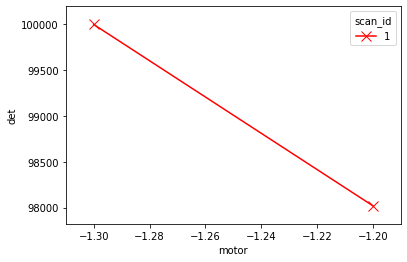

In [5]:
from ophyd.sim import SynAxis, SynGauss
motor = SynAxis(name='motor')
det = SynGauss(name='det', motor=motor, motor_field='motor', center=-1.3, Imax=1e5, sigma=0.5, noise="uniform",noise_multiplier=1)


from bluesky import RunEngine

RE=RunEngine({})
#Set up plotting
from bluesky.callbacks.best_effort import BestEffortCallback
from event_model import RunRouter

from bluesky.callbacks.mpl_plotting import LivePlot

num = 10                    #The number of points used in each pass
scale_factor = 3            #How much the range of each pass is scaled by.
required_precision = 0.01  #Required precision of the motor
low_range = -2.5
high_range = 0.5
RE(bps.mov(motor,-1.3))
RE(human_max_search([det], "det", motor, 0.1),LivePlot('det', 'motor',marker='x', markersize=10, color='red'))